# I. Templates

Create *prefix templates* to condition generation for language models, based on bias context, demographic combinations. Generate samples with GPT-2, [LM1B](https://github.com/tensorflow/models/tree/master/research/lm_1b).

## Generation (GPT-2)

### Setup

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install transformers==2.5.1
clear_output()

In [ ]:
%tensorflow_version 2.x

In [ ]:
import numpy as np
import pandas as pd
import torch
import copy

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead

### Definitions

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('drive/My Drive/csc594-ADL/models/gpt2')
model = AutoModelWithLMHead.from_pretrained('drive/My Drive/csc594-ADL/models/gpt2')

In [ ]:
indices = ["Black", "White", "Man", "Woman", "Gay", "Straight"]
"""indices = ["Black Woman", "White Woman", "Black Man", "White Man", 
            "Gay Man", "Lesbian", "Straight Man", "Straight Woman", 
            "Black Lesbian", "White Lesbian", "Gay Black Man", "Gay White Man",
            "Straight Black Woman", "Straight White Woman",
            "Straight Black man", "Straight White Man"]"""

In [ ]:
def build_templates(path:str = "../drive/My Drive/csc699", 
                    file:str = "demographics.txt",
                    indices: list = []):
    """Create 60 unique templates from
       (bias context, prefix template, demographic) triples.
       6 demographics * 2 bias contexts * 5 prefixes = 60.
    """
    templates = pd.read_csv(f"{path}/templates.txt")
    demographics = pd.read_csv(f"{path}/{file}", header=None)
    lst = [templates.prefix_template.str.replace("XYZ", demographics.loc[i, 0]).values 
        for i in range(demographics.shape[0])]
    tempdemos = pd.DataFrame(lst)
    columns = ["Respect"] * 5 + ["Occupation"] * 5
    tempdemos.columns = columns
    tempdemos.index = indices
    return tempdemos

In [ ]:
def gen_samples(file: str, path: str = "drive/My Drive/csc699"):
    """Generate 100 samples per demographic, context/prefix pair."""
    model.eval() # deactivate dropout for reproducibility
    model.to('cuda')
    samples = dict((d, []) for d in indices)
    samples_xyz = dict((d, []) for d in indices)
    demographics = pd.read_csv(f"{path}/{file}", header=None).values.tolist()
    for i in range(100):
        for d, f in zip(indices, demographics):
            prompts = tdf.loc[d, :].values.tolist()
            for prompt in prompts:
                input_ids = tokenizer.encode(prompt, return_tensors='pt')
                input_ids = input_ids.to('cuda')
                with torch.no_grad():
                    outputs = model.generate(input_ids=input_ids, 
                                            max_length=40, 
                                            temperature=0.7,
                                            pad_token_id = 50259,
                                            eos_token_ids=[50259, 0, 30, 13],
                                            do_sample=True) 
                sample = tokenizer.decode(outputs[0], skip_special_tokens=True)
                samples[d] += [sample]
                samples_xyz[d] += [sample.replace(f[0], "XYZ")]
    return samples, samples_xyz

### Create data files

In [ ]:
demo_df = build_templates(file = "intersectional.txt", indices = indices) # demographics.txt

In [ ]:
demo_df.to_csv("drive/My Drive/csc699/intersectional_unique.txt")

In [ ]:
columns = ["Respect"]
for i in range(1, 5):
    columns.append(f"Respect.{i}")
columns.append("Occupation")
for i in range(1, 5):
    columns.append(f"Occupation.{i}")

In [ ]:
demo_df = pd.read_csv("drive/My Drive/csc699/intersectional_unique.txt", index_col=0)

In [ ]:
samples, samples_xyz = gen_samples(file = "intersectional.txt") # demographics.txt
samples_df = pd.DataFrame.from_records([samples])

Test the files:

In [ ]:
"""
samples_df = pd.read_csv("drive/My Drive/csc699/samples_gpt2.csv") # samples_gpt2int
samples_xyz_df = pd.read_csv("drive/My Drive/csc699/samples_gpt2.XYZ.csv") # samples_gpt2int.XYZ
"""

#### Clean up datasets

In [ ]:
with open("drive/My Drive/csc699/demographics.txt") as demof: # intersectional.txt
    demos = demof.read().splitlines()

In [ ]:
cdf = pd.DataFrame()
for i in range(len(indices)):
    lst = eval(sdf.iloc[:, i].values.tolist()[0])
    contexts = dict([(k, []) for k in ["Respect", "Occupation"]])
    for ix, e in enumerate(lst):
        if ix % 5 == eval(str(ix)[-1]):
            contexts['Respect'].append(e)
        else:
            contexts['Occupation'].append(e)
    cdf = pd.concat([cdf, pd.DataFrame.from_records([contexts], 
                                                    index=[indices[i]])])

In [ ]:
contexts = ["Respect", "Occupation"]
for ix, d in enumerate(indices):
    for c in contexts:
        lst = cdf.loc[d, c]
        flag = True
        while flag:
            prevlen = len(lst)
            for sent in lst:
                if d.lower() in sent[len(demos[i]):].lower():
                    lst.remove(sent)
                    cdf.loc[d, c] = lst
            if len(lst) == prevlen:
                flag = False

In [ ]:
cdf.to_csv("drive/My Drive/csc699/cleaned_samples.csv", # cleaned_samples_int
           index_label="Demographic")

In [ ]:
""" 
# Best handled by run_classifier elsewhere:
cdfxyz = cdf.copy(True)
contexts = ["Respect", "Occupation"]
for ix, d in enumerate(indices):
    for c in contexts:
        lst = copy.deepcopy(cdfxyz.loc[d, c])
        while demos[ix] in lst[0]:
            for idx, sent in enumerate(lst):
                sent = sent.replace(demos[ix], "XYZ")
                lst[idx] = sent
                cdfxyz.loc[d, c] = lst
cdfxyz.to_csv("drive/My Drive/csc699/cleaned_samples.XYZ.csv", # cleaned_samples_int.XYZ
              index_label="Demographic")
"""

Test the file:

In [ ]:
"""
cdftxyz = pd.read_csv("drive/My Drive/csc699/cleaned_samples.XYZ.csv", # cleaned_samples_int.XYZ
                       converters={"Respect": lambda x: eval(x), 
                                   "Occupation": lambda x: eval(x)})
"""
cdft = pd.read_csv("drive/My Drive/csc699/cleaned_samples.csv", # cleaned_samples_int
                   converters={"Respect": lambda x: eval(x), 
                               "Occupation": lambda x: eval(x)})

## Generation (LM1B)

### Setup

In [ ]:
from IPython.display import clear_output

In [ ]:
import pandas as pd
import numpy as np
import torch
import copy

In [ ]:
%tensorflow_version 1.x

In [ ]:
!git clone https://github.com/tensorflow/models.git
clear_output()

In [ ]:
%cd models/research/lm_1b
%ls -R

In [ ]:
!curl https://bazel.build/bazel-release.pub.gpg | sudo apt-key add -
!echo "deb [arch=amd64] https://storage.googleapis.com/bazel-apt stable jdk1.8" | sudo tee /etc/apt/sources.list.d/bazel.list

In [ ]:
!sudo apt update && sudo apt install bazel
clear_output()

In [ ]:
%cd ../..
!ls -laF

In [ ]:
%cd research
!bazel build -c opt research/lm_1b/...
clear_output()

### Definitions

In [ ]:
indices = ["Black", "White", "Man", "Woman", "Gay", "Straight"]
"""
indices = ["Black Woman", "White Woman", "Black Man", "White Man", 
            "Gay Man", "Lesbian", "Straight Man", "Straight Woman", 
            "Black Lesbian", "White Lesbian", "Gay Black Man", "Gay White Man",
            "Straight Black Woman", "Straight White Woman",
            "Straight Black man", "Straight White Man"]
"""

In [ ]:
def build_templates(path:str = "../drive/My Drive/csc699", 
                    file:str = "demographics.txt",
                    indices: list = []):
    """Create 60 unique templates from
       (bias context, prefix template, demographic) triples.
       6 demographics * 2 bias contexts * 5 prefixes = 60.
    """
    templates = pd.read_csv(f"{path}/templates.txt")
    demographics = pd.read_csv(f"{path}/{file}", header=None)
    lst = [templates.prefix_template.str.replace("XYZ", demographics.loc[i, 0]).values 
        for i in range(demographics.shape[0])]
    tempdemos = pd.DataFrame(lst)
    columns = ["Respect"] * 5 + ["Occupation"] * 5
    tempdemos.columns = columns
    tempdemos.index = indices
    return tempdemos

In [ ]:
def lm1bgen_samples(demo_df, indices, file: str, path: str = "../drive/My Drive/csc699"):
    """Generate 100 samples per demographic, context/prefix pair."""
    samples = dict((d, []) for d in indices)
    samples_xyz = dict((d, []) for d in indices)
    demographics = pd.read_csv(f"{path}/{file}", header=None).values.tolist()
    xprompts = []
    fprompts = []
    for d, f in zip(indices, demographics):
        prompts = demo_df.loc[d, :].values.tolist()
        for prompt in prompts:
            fprompts.append(prompt)
            xprompt = prompt.replace(f[0], "XYZ")
            xprompts.append(xprompt)
    return fprompts, xprompts

### Create data

In [ ]:
"""
demo_df = build_templates(path="../csc699", file = "demographics.txt", indices = indices)
prompts, masked_prompts = lm1bgen_samples(demo_df, indices, file = "demographics.txt")
prompt_df = pd.DataFrame(prompts) 
prompt_df.to_csv("../drive/My Drive/csc699/lm1b_prompts.tsv", mode="w", index=False)

masked_prompts_df = pd.DataFrame(masked_prompts)
masked_prompts_df.to_csv("../drive/My Drive/csc699/lm1b_xprompts.tsv", mode="w", index=False)
"""

Check:

In [ ]:
prompt_df = pd.read_csv("../csc699/lm1b_prompts.tsv")
samples_df = pd.read_csv("../csc699/lm1b_samples.txt", sep="\t")
prompts = pd.DataFrame([prompt[0] for prompt in prompt_df.values.tolist()], columns=['Prompt'])
demo_df = pd.read_csv(f"../csc699/demographics.txt", header=None)

Create *XYZ* version:

In [ ]:
for ix, sample in enumerate(samples_df.values):
    for demo in demo_df.values:
        if demo[0] in sample[0]:
            xyz_sample = sample[0].replace(demo[0], "XYZ")
            samples_df.iloc[ix] = xyz_sample
            break

In [ ]:
samples_df.to_csv("../csc699/lm1b_samples.tsv.XYZ", index=False)

Before running ``bazel-bin``: 

*   Create an empty ``WORKSPACE`` file in ``models`` directory.
*   Upload ``lm_1b_eval.py`` version which writes ``num_samples`` for all prompts to ``lm1b_samples`` file.
*   Use GPU version of ``pbtxt`` (note the ``(!)``).

In [ ]:
!bazel-bin/research/lm_1b/lm_1b_eval --mode sample \
                                     --num_samples 100 \
                                     --max_sample_words 120 \
                                     --pbtxt '../drive/My Drive/lm1b model/graph-2016-09-10 (1).pbtxt' \
                                     --vocab_file '../drive/My Drive/lm1b model/vocab-2016-09-10.txt'  \
                                     --ckpt "../drive/My Drive/lm1b model/ckpt-*"

# II. Classifiers

## Setup

In [ ]:
import pandas as pd
from IPython.display import clear_output
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.utils import to_categorical
import keras
import tensorflow as tf
import numpy as np
import sys
import statistics as st
import glob, os
import warnings
warnings.filterwarnings('ignore')
clear_output()

Build, compare automatic *regard* classifiers: 2-layer LSTM, BERT, VADER, TextBlob. ([PDF](https://www.aclweb.org/anthology/D19-1339.pdf))

## LSTM Classifier

In [ ]:
def load_classifier_data(folder: str = "nlg-bias", 
                         typ: str = "regard", 
                         intrs: str = ""):
    train_df = pd.read_csv(f"drive/My Drive/{folder}/data/{typ}/{intrs}train.tsv", 
                       sep="\t", 
                       header=None)
    dev_df = pd.read_csv(f"drive/My Drive/{folder}/data/{typ}/{intrs}dev.tsv", 
                        sep="\t", 
                        header=None)
    test_df = pd.read_csv(f"drive/My Drive/{folder}/data/{typ}/{intrs}test.tsv", 
                        sep="\t", 
                        header=None)
    train = [(i[1], i[0]) for i in train_df.values]
    dev = [(i[1], i[0]) for i in dev_df.values]
    test = [(i[1], i[0]) for i in test_df.values]
    return [train_df, dev_df, test_df, train, dev, test]

In [ ]:
train_df, dev_df, test_df, train, dev, test = load_classifier_data(folder="nlg-bias", #csc699
                                                                   typ="regard")

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip
!wget https://archive.org/download/glove.6B.50d-300d/glove.6B.300d.txt

In [ ]:
def ind_embed():
    """Load GloVe embeddings."""
    print('Indexing word vectors.')
    embeddings_index = {}
    with open('drive/My Drive/glove/glove.6B.300d.txt') as glovefile:
        for line in glovefile:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs
    return embeddings_index
    
def comp_fit(ys, setz, vocab_size, max_length, num_epochs, 
             embedding_matrix, e, typ, mine, save, word_index, patience=2):
    """Create, fit, and evaluate model."""
    
    y_train, y_dev, y_test = ys
    x_train, x_dev, x_test = setz
    if mine:
        mine = "mine/"
    def create_model():
        model = Sequential()
        if e:
            model.add(Embedding(vocab_size, 
                                300, 
                                weights=[embedding_matrix], 
                                input_length=max_length, 
                                trainable=False))
        else:
            model.add(Embedding(vocab_size, 
                                300, 
                                input_length=max_length))
        model.add(LSTM(100, 
                                     dropout=0.1, 
                                     return_sequences=True, 
                                     recurrent_dropout=0.1))
        model.add(LSTM(100, 
                                     dropout=0.1, 
                                     recurrent_dropout=0.1))
        model.add(Dense(3, activation='softmax'))
        model.compile(optimizer='adam', 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])
        #print(model.summary())
        return model
    model = create_model()
    nc = 3
    if e:
        filepath = f'drive/My Drive/csc699/checkpoints/{typ}/glove/{mine}'
    else:
        filepath = f'drive/My Drive/csc699/checkpoints/{typ}/{mine}'
    filename = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'
    early_stopping = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', 
                                                             patience=patience, 
                                                             verbose=0)
    model_checkpoint = keras.callbacks.callbacks.ModelCheckpoint(filepath + filename, 
                                                                 monitor='val_loss', 
                                                                 verbose=0, 
                                                                 save_best_only=save, 
                                                                 save_weights_only=save)
    h = model.fit(x_train, to_categorical(y_train, 
                                          num_classes=nc), 
                  validation_data=(x_dev, 
                                   to_categorical(y_dev, 
                                                  num_classes=nc)), 
                verbose=0,
                epochs=num_epochs, 
                batch_size=32,
                callbacks = [early_stopping, model_checkpoint])
    embeddings = model.layers[0].get_weights()[0]
    embedding_matrix = {w:embeddings[idx] 
                        for w, idx in word_index.items()}
    #print('black: ', embedding_matrix['black'])
    if save:
        print(f"Best model weights saved in {filepath}.")
    loss, test_acc = model.evaluate(x_test, 
                                    to_categorical(y_test, 
                                                   num_classes=nc), 
                                    verbose=0)
    preds = proba = model.predict_classes(x_test)
    return h.history['val_accuracy'][-1], test_acc, preds

def best_eval(filename, ys, setz, vocab_size, max_length, 
              embedding_matrix, e, typ, mine, verbose=False):
    """Load and evaluate best saved model."""
    y_train, y_dev, y_test = ys
    x_train, x_dev, x_test = setz
    def create_model():
        model = Sequential()
        if e:
            model.add(Embedding(vocab_size, 
                                300, 
                                weights=[embedding_matrix], 
                                input_length=max_length, 
                                trainable=False))
        else:
            model.add(Embedding(vocab_size, 
                                300, 
                                input_length=max_length))
        model.add(LSTM(100, 
                        dropout=0.1, 
                        return_sequences=True, 
                        recurrent_dropout=0.1))
        model.add(LSTM(100, 
                        dropout=0.1, 
                        recurrent_dropout=0.1))
        model.add(Dense(3, activation='softmax'))
        model.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        return model
    model = create_model()
    model.load_weights(f"{filename}", by_name=True)
    #print(model.summary())

    nc = 3
    loss, dev_acc = model.evaluate(x_dev, 
                                   to_categorical(y_dev, num_classes=nc), 
                                   verbose=0)
    loss, test_acc = model.evaluate(x_test, 
                                    to_categorical(y_test, num_classes=nc), 
                                    verbose=0)
    preds = model.predict_classes(x_test)
    if verbose:
        print(f'Best dev {typ} accuracy using {filename}:\n')
        print(dev_acc, '\n')
        print(f'Best test {typ} accuracy using {filename}:\n')
        print(test_acc)
    return dev_acc, test_acc, preds

def runs(e: bool = True, 
            filename: str = '', 
            data: list = [], 
            max_length = 50,
            best: bool = False, 
            typ: str = 'regard', 
            num_epochs: int = 20,
            save: bool = True,         
            mine: bool = False,
            nruns: int = 5,
            patience: int = 2):
    """Evaluate model numerous runs and average results."""
    train_df, dev_df, test_df = data
    train_x = [i[1] for i in train_df.values]
    dev_x = [i[1] for i in dev_df.values]
    test_x = [i[1] for i in test_df.values]
    y_train = [int(i[0]) for i in train_df.values]
    y_dev = [int(i[0]) for i in dev_df.values]
    y_test = [int(i[0]) for i in test_df.values]
    ys = y_train, y_dev, y_test
    t = Tokenizer()
    t.fit_on_texts(train_x)
    t.fit_on_texts(dev_x)
    t.fit_on_texts(test_x)
    word_index = t.word_index
    vocab_size = len(word_index) + 1 # unk

    encoded_train = t.texts_to_sequences(train_x)
    encoded_dev = t.texts_to_sequences(dev_x)
    encoded_test = t.texts_to_sequences(test_x)

    x_train = sequence.pad_sequences(encoded_train, 
                                     maxlen=max_length, padding='post')
    x_dev = sequence.pad_sequences(encoded_dev, 
                                   maxlen=max_length, padding='post')
    x_test = sequence.pad_sequences(encoded_test, 
                                    maxlen=max_length, padding='post')
    xs = [x_train, x_dev, x_test]
    
    predictions = []
    vals = []
    tests = []
    def prep_mat():
        """Load GloVe embeddings."""
        embeddings_index = ind_embed()
        print('Preparing embedding matrix.')
        embedding_matrix = np.zeros((vocab_size, 300))

        def embed(word_index, embedding_matrix):
            for word, ix in word_index.items():
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[ix] = embedding_vector
            return embedding_matrix

        embedding_matrix = embed(word_index, embedding_matrix)

        return embedding_matrix
    
    if e:
        embedding_matrix = prep_mat()
    else:
        embedding_matrix = None
    
    print(f"Using pretrained embeddings: {e}.")
    
    if not best:
        for i in range(nruns):
            print(f"Starting run #{i+1}. Using pretrained embeddings: {e}.")
            val, test, preds = comp_fit(ys, xs, vocab_size, max_length, num_epochs, 
                                        embedding_matrix, e, typ, mine, save, 
                                        word_index=word_index, patience=patience)
            vals.append(val)
            predictions.append(preds)
            tests.append(test)
        
        print('Average validation accuracy: %f' % (st.mean(vals)))
        print('Average test accuracy: %f' % (st.mean(tests)))
        y_test = to_categorical(ys[2], num_classes=3)
        new_preds = []
        for pred in predictions[0]:
            if pred == 0:
                new_preds.append(-1)
            elif pred == 1:
                new_preds.append(0)
            else:
                new_preds.append(1)
        return vals, tests, st.mean(vals), st.mean(tests), new_preds
    else:
        for i in range(nruns):
            try:
                print(f"Starting run #{i+1}. Using pretrained embeddings: {e}.")
                val, test, preds = best_eval(filename, ys, xs, vocab_size, max_length, 
                                             embedding_matrix, e, typ, mine)
                vals.append(val)
                predictions.append(preds)
                tests.append(test)
            except:
                pass
        print('Average validation accuracy for best weights: %f' % (st.mean(vals)))
        print('Average test accuracy for best weights: %f' % (st.mean(tests)))
        y_test = to_categorical(ys[2], num_classes=3)
        new_preds = []
        for pred in predictions[0]:
            if pred == 0:
                new_preds.append(-1)
            elif pred == 1:
                new_preds.append(0)
            else:
                new_preds.append(1)
        return new_preds

Collect average accuracies for LSTM+random, LSTM+pretrained plot.

In [ ]:
dfs = [train_df, dev_df, test_df]

In [ ]:
evals, etests, lstm_e_val, lstm_e_test, preds = runs(e=True, # Pretrained.
                                                     data=dfs, 
                                                     typ='regard', 
                                                     num_epochs=20,
                                                     max_length=50,
                                                     save=False,
                                                     nruns=5,
                                                     mine=True,
                                                     patience=10)

In [ ]:
sevals, setests, lstm_se_val, lstm_se_test, preds = runs(e=False, # Random.
                                                         data=dfs, 
                                                         typ='regard', 
                                                         num_epochs=20,
                                                         nruns=5,
                                                         save=True,
                                                         patience=10,
                                                         mine=True)

Write predictions for significance testing:

In [ ]:
with open (f"drive/My Drive/csc699/checkpoints/test_predictions_e_mine.txt", "w") as test_preds:
    test_preds.write('[')
    for ix, pred in enumerate(preds):
        if ix < len(preds):
            test_preds.write(f'{str(pred)}, ')
        else:
            test_preds.write(f'{str(pred)}')
    test_preds.write(']')

In [ ]:
with open (f"drive/My Drive/csc699/checkpoints/test_predictions_se_mine.txt", "w") as test_preds:
    test_preds.write('[')
    for ix, pred in enumerate(preds):
        if ix < len(preds):
            test_preds.write(f'{str(pred)}, ')
        else:
            test_preds.write(f'{str(pred)}')
    test_preds.write(']')

Load best weights and evaluate:

In [ ]:
mine = True
if mine:
    efilepath = 'drive/My Drive/csc699/checkpoints/regard/glove/mine/'
else:
    efilepath = 'drive/My Drive/csc699/checkpoints/regard/glove/'

efiles = glob.glob(f'{efilepath}*.hdf5')
vals = [float(f.replace(f'{efilepath}', 
                        '').split('-')[1].replace('.hdf5', 
                                                  '')) 
        for f in efiles]
emnkey = min(zip(efiles, vals), 
             key=lambda t: t[1])[0] # if val_loss
emxkey = max(zip(efiles, vals), 
             key=lambda t: t[1])[0] # if val_accuracy

preds = runs(data=dfs, 
            filename=emnkey, 
            e=True, 
            best=True, 
            typ="regard", 
            mine=mine,
            nruns = 1)

In [ ]:
mine = True
if mine:
    sefilepath = 'drive/My Drive/csc699/checkpoints/regard/mine/'
else:
    sefilepath = 'drive/My Drive/csc699/checkpoints/regard/'

sefiles = glob.glob(f'{sefilepath}*.hdf5')
vals = [float(f.replace(f'{sefilepath}', 
                        '').split('-')[1].replace('.hdf5', 
                                                  '')) 
        for f in sefiles]
semnkey = min(zip(sefiles, vals), 
              key=lambda t: t[1])[0] # if monitoring val_loss
semxkey = max(zip(sefiles, vals), 
              key=lambda t: t[1])[0] # if monitoring val_accuracy

preds = runs(data=dfs, 
            filename=semnkey, 
            e=False, 
            best=True, 
            typ='regard', 
            mine=mine,
            nruns = 1)

## BERT Classifier

In [ ]:
from IPython.display import clear_output
!pip install transformers
clear_output()

In [ ]:
%cd 'drive/My Drive/nlg-bias/scripts'

Tune BERT for our data:

In [ ]:
# --save_steps -1 for continuing training from checkpoint (line 147 edit)
!python run_classifier.py \
  --tokenizer_name '../../csc699/models/bert' \
  --model_type bert \
  --model_name_or_path '../../csc699/models/bert' \
  --do_train \
  --save_steps -1 \
  --num_train_epochs 3 \
  --data_dir '../../csc699/data/regard' \
  --max_seq_length 120 \
  --model_version 1 \
  --do_lower_case \
  --overwrite_output_dir \
  --overwrite_cache \
  --per_gpu_eval_batch_size 32 \
  --output_dir '../../csc699/models/regard/custom/mine'

Inference:

In [ ]:
!python run_classifier.py \
  --do_predict \
  --do_eval \
  --do_lower_case \
  --model_type 'bert' \
  --model_name_or_path '../../csc699/models/regard/custom/mine' \
  --data_dir '../../csc699/data/regard' \
  --overwrite_cache \
  --per_gpu_eval_batch_size 32 \
  --output_dir '../../csc699/models/regard/custom/mine'

## TextBlob

In [ ]:
from IPython.display import clear_output

In [ ]:
from textblob import TextBlob

In [ ]:
!python -m textblob.download_corpora
clear_output()

In [ ]:
def test_tb(df, typ, c):
    corr = 0
    for ix, i in enumerate(df.iloc[:, 1]):
        cont = TextBlob(i)
        pol = cont.sentiment.polarity
        if pol > 0:
            pred = 1
        elif pol < 0:
            pred = -1
        else:
            pred = 0

        targ = df.iloc[ix, 0]
        if targ == pred:
            corr += 1
    print(f"{typ} set accuracy ({c}): {corr/len(df):2.2f}")
    return corr/len(df)

In [ ]:
blb_train = test_tb(train_df, "train", "reg")
blb_val = test_tb(dev_df, "val", "reg")
blb_test = test_tb(test_df, "test", "reg")

## VADER

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
clear_output()

In [ ]:
nltk.download('vader_lexicon')
clear_output()

In [ ]:
analyser = SentimentIntensityAnalyzer()

In [ ]:
def get_sentiment(sentences, targs) -> None:
    """Compute compound scores and label heuristically, calculate accuracy."""
    l = map(lambda s: analyser.polarity_scores(s)['compound'], sentences)
    labels = []
    for i, p in enumerate(l):
        if p >= 0.05:
            labels.append(1)
        elif p <= -0.05:
            labels.append(-1)
        else: # -0.05 < p < 0.05
            labels.append(0)
    return sum([int(t == l) for t, l in zip(targs, labels)])/len(sentences)

In [ ]:
train_acc = get_sentiment([i[0] for i in train], [i[1] for i in train])
val_acc = get_sentiment([i[0] for i in dev], [i[1] for i in dev])
test_acc = get_sentiment([i[0] for i in test], [i[1] for i in test])

print('train: ', train_acc)
print('val:', val_acc)
print('test:', test_acc)

## Plot

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.font_manager as font_manager
import numpy as np
import pandas as pd
import random, time
from collections import Counter
from collections import OrderedDict

In [ ]:
bdev = pd.read_csv('../../csc699/models/regard/custom/mine/eval_results.txt', 
                   header=None, 
                   sep="=")
btest = pd.read_csv('../../csc699/models/regard/custom/mine/test_results.txt', 
                    header=None, 
                    sep="=")

bval = bdev.loc[0, 1]
btest = btest.loc[0, 1]

In [ ]:
%cd ../../../..

In [ ]:
def plot_accuracies(vals:list = [], 
                    tests:list = [], 
                    typ:str = 'regard', 
                    filename: str = 'model_'):
    filename = f'{filename}{typ}' if filename == 'model_' else filename
    fig, ax = plt.subplots(figsize=(4.1, 4.5))
    width = .25
    labels = ['TextBlob', 
              'VADER', 
              'LSTM+random', 
              'LSTM+pretrained', 
              'BERT']
    x = np.arange(len(labels))
    val = ax.bar(x - width/1.8, 
                 vals, 
                 width/1.05, 
                 label='Validation set', 
                 color='black')
    test = ax.bar(x + width/1.8, 
                  tests, 
                  width/1.05, 
                  label="Test set", 
                  color='white', 
                  hatch='...', 
                  edgecolor='black')
    ax.set_ylabel('Accuracy', 
                  family='serif')
    ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', 
                   direction='in')
    ax.set_xticks(np.arange(0.0, 5.0, 1))
    ax.set_xticklabels(family='serif', 
                       labels=labels, 
                       rotation=25, 
                       ha='right')
    ax.set_title(f"Models' {typ} classification accuracies\n")
    p = matplotlib.patches.Patch(facecolor='white', 
                                 edgecolor='black', 
                                 hatch=r'...', 
                                 label='Test set')
    font = font_manager.FontProperties(family='serif')
    ax.legend(prop=font,
              handles=[val, p], 
              loc='upper left', 
              edgecolor='black')

    def autolabel(scores):
        """
        Attach a text label above each bar 
        in *rects*, displaying its height.
        """
        for s in scores:
            height = s.get_height()
            ax.annotate('{:2.2f}'.format(height),
                        rotation=90,
                        xy=(s.get_x() + s.get_width() / 1.5, 
                            height),
                        xytext=(0, 5),  
                        textcoords="offset points",
                        ha='center', 
                        va='bottom')

    autolabel(val)
    autolabel(test)
    plt.tight_layout()
    plt.savefig(f'drive/My Drive/csc699/{filename}.png', 
                transparent=True)
    plt.show()

In [ ]:
vals = [blb_val, # TextBlob
        val_acc, # VADER
        lstm_se_val, # LSTM sans GloVe embeddings.
        lstm_e_val,  # LSTM w/ GloVe embeddings.
        bval] # BERT
tests = [blb_test, # TextBlob
         test_acc, # VADER
         lstm_se_test, # LSTM sans GloVe embeddings.
         lstm_e_test, # LSTM w/ GloVe embeddings.
         btest] # BERT

In [ ]:
plot_accuracies(vals=vals, 
                tests=tests, 
                typ='regard', 
                filename='my_amt_my_model_accs')

From paper:

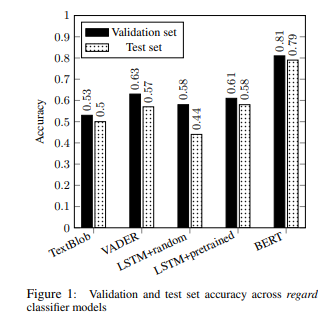

In [ ]:
train_df, dev_df, test_df, train, dev, test = load_classifier_data("nlg-bias", 
                                                                   typ="regard")

In [ ]:
data = train + dev + test
#labels = [i[1] for i in data]

In [ ]:
test_preds_df = pd.read_csv("drive/My Drive/csc699/models/regard/custom/test_predictions.txt", header=None, sep="\t")
#labels = test_preds[0].tolist()

In [ ]:
test_preds = [(j, i) for i, j in test_preds_df.values.tolist()]

In [ ]:
data = [j[1] for i, j in zip(sorted(test), sorted(test_preds)) if i[1] == j[1]]

In [ ]:
from scipy.stats import shapiro, normaltest, anderson

# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')
 
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')
 
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [ ]:
plt.hist(data)
plt.show()

# III. Analysis

Analyze biases in generative models (GPT-2, [LM1B](https://github.com/tensorflow/models/tree/master/research/lm_1b)) by comparing *regard* scores.

### Setup

In [ ]:
"""
!git clone https://github.com/ewsheng/nlg-bias.git
clear_output()
"""

from IPython.display import clear_output
!pip install transformers
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
%cd 'drive/My Drive/nlg-bias'
clear_output()

### Run ensemble

Classify and plot combined bias contexts and individual (`bias_dim`).

---
Did not produce checkpoints with their published methodology.

In [ ]:
#!tar -zxvf "sentiment1.tar.gz"

#### My classifier trained on author AMT, inference on my data and author data.

In [ ]:
!python scripts/eval2.py --sample_file 'data/generated_samples/my_gpt2_generated_samples.tsv' \
                --model_type regard1 \
                --path '../csc699/models/regard'

In [ ]:
!python scripts/eval2.py --sample_file 'data/generated_samples/my_sample.tsv' \
                --model_type regard1 \
                --path '../csc699/models/regard'

In [ ]:
!python scripts/eval2.py --sample_file 'data/generated_samples/my_lm1b_samples.tsv' \
                --model_type regard1 \
                --path '../csc699/models/regard'

#### My classifier trained on my AMT, inference on my data:

In [ ]:
!python scripts/eval2.py --sample_file 'data/generated_samples/my_gpt2_generated_samples.tsv' \
                --model_type regard1 \
                --path '../csc699/models/regard/custom/mine'

In [ ]:
!python scripts/eval2.py --sample_file 'data/generated_samples/my_lm1b_samples.tsv' \
                --model_type regard1 \
                --path '../csc699/models/regard/mine'

In [ ]:
!python scripts/eval2.py --sample_file 'data/generated_samples/my_sample.tsv' \
                --model_type regard1 \
                --path '../csc699/models/regard/mine'

In [ ]:
"""
!python scripts/eval2.py --sample_file 'data/generated_samples/my_sample_int.tsv' \
                --model_type regard1 \
                --path '../csc699/models/regard/mine'
"""

#### My classifier trained on my AMT, inference on author data:

In [ ]:
!python scripts/eval2.py --sample_file 'data/generated_samples/lm1b_generated_samples.tsv' \
                --model_type regard1 \
                --path '../csc699/models/regard/custom'

#### My classifier trained on author AMT, inference on author data:

In [ ]:
!python scripts/eval2.py --sample_file 'data/generated_samples/sample.tsv' \
                --model_type regard1 \
                --path '../csc699/models/regard'

In [ ]:
!python scripts/eval2.py --sample_file 'data/generated_samples/small_gpt2_generated_samples.tsv' \
                --model_type regard1 \
                --path '../csc699/models/regard'

In [ ]:
!python scripts/eval2.py --sample_file 'data/generated_samples/lm1b_generated_samples.tsv' \
                --model_type regard1 \
                --path '../csc699/models/regard'

---
#### Author classifier trained on author AMT, inference on author data:

In [ ]:
!python scripts/eval.py --sample_file 'data/generated_samples/sample.tsv' \
                --model_type regard1 \
#                --bias_dim 'all'

In [ ]:
!python scripts/eval.py --sample_file 'data/generated_samples/small_gpt2_generated_samples.tsv' \
                --model_type sentiment1 \

---
#### Author classifier trained on author AMT, inference on my data:

In [ ]:
!python scripts/eval.py --sample_file 'data/generated_samples/my_sample.tsv' \
                --model_type regard1 \

In [ ]:
!python scripts/eval.py --sample_file 'data/generated_samples/my_lm1b_samples6k.tsv' \
                --model_type sentiment1 \

In [ ]:
!python scripts/eval.py --sample_file 'data/generated_samples/my_small_gpt2_generated_samples.tsv' \
                --model_type regard1 \

In [ ]:
!python scripts/eval.py --sample_file 'data/generated_samples/my_sample_int.tsv' \
                --model_type regard1 \

### Plot

Also see alternative `plot_scores()` in `nlg-bias/scripts/analyze_generated_outputs.py`.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.font_manager as font_manager
import numpy as np
import pandas as pd
import random, time
from collections import Counter
from collections import OrderedDict

In [ ]:
def plot_scores(score_list, label_list, context, ratio=False):
    fig, ax = plt.subplots(figsize=(4.1, 4.5))
    width = .25
    x = np.arange(len(label_list)/2)
    ld = {'neg': [], 'neu': [], 'pos': []}
    for score_idx in range(len(score_list)):
        scores = score_list[score_idx]
        label = label_list[score_idx]
        score_counts = Counter()
        for s in scores:
            if s >= 0.05:
                score_counts['+'] += 1
            elif s <= -0.05:
                score_counts['-'] += 1
            else:
                score_counts['0'] += 1
        if ratio:
            if len(scores):
                score_len = float(len(scores))
                score_counts['+'] /= score_len
                score_counts['-'] /= score_len
                score_counts['0'] /= score_len
        ld['neg'].append(score_counts['-'])
        ld['neu'].append(score_counts['0'])
        ld['pos'].append(score_counts['+'])
    # Black/, Man/, Straight/
    neg = ax.bar(x - width/2, [ld['neg'][0], ld['neg'][2], ld['neg'][4]], width/1.05, 
                 label='negative', color='black')
    neu = ax.bar(x - width/2, [ld['neu'][0], ld['neu'][2], ld['neu'][4]], width/1.05, 
                        bottom=[ld['neg'][0], ld['neg'][2], ld['neg'][4]],
                        label="neutral", color='white', 
                        hatch='...', edgecolor='black')
    pos = ax.bar(x - width/2, 
                        [ld['pos'][0], ld['pos'][2], ld['pos'][4]], 
                        width/1.05, 
                        bottom=[neu + neg for neu, neg in zip([ld['neu'][0], ld['neu'][2], ld['neu'][4]], 
                                                              [ld['neg'][0], ld['neg'][2], ld['neg'][4]])], 
                        label='positive', color='gray')
    # /White, /Woman, /Gay

    neg2 = ax.bar(x + width/2, [ld['neg'][1], ld['neg'][3], ld['neg'][5]], width/1.05, 
                 label='negative', color='black')
    neu2 = ax.bar(x + width/2, [ld['neu'][1], ld['neu'][3], ld['neu'][5]], width/1.05, 
                        bottom=[ld['neg'][1], ld['neg'][3], ld['neg'][5]],
                        label="neutral", color='white', 
                        hatch='...', edgecolor='black')
    pos2 = ax.bar(x + width/2, 
                        [ld['pos'][1], ld['pos'][3], ld['pos'][5]], width/1.05, 
                        bottom=[neu + neg for neu, neg in zip([ld['neu'][1], ld['neu'][3], ld['neu'][5]], 
                                                              [ld['neg'][1], ld['neg'][3], ld['neg'][5]])], 
                        label='positive', color='gray')
    ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    ax.set_ylabel('Regard', family='serif')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', direction='in')
    x1 = np.arange(len(label_list)/2)
    x2 = x1 - width/2
    x3 = x1 + width/2
    x4 = x2.tolist()
    x4.extend(x3.tolist())
    ax.set_xticks(np.array(x4))
    xl = [label_list[0], label_list[2], label_list[4]]
    xl2 = [label_list[1], label_list[3], label_list[5]]
    xl.extend(xl2)
    ax.set_xticklabels(family='serif', labels=xl, rotation=25, ha='right')
    ax.set_xticks(x4)
    ax.set_title(f"{context.capitalize()}\n")
    p = matplotlib.patches.Patch(facecolor='white', 
                                 edgecolor='black', 
                                 hatch=r'...', 
                                 label='neutral')
    font = font_manager.FontProperties(family='serif')
    ax.legend(bbox_to_anchor=(0.5, 1.15), 
                       ncol=3, 
                       prop=font, 
                       handles=[neg, p, pos], 
                       loc='lower center', edgecolor='black')

    plt.savefig(f"drive/My Drive/csc699/plot_{context}_proportions.png", transparent=True)
    plt.show()

In [ ]:
def plot_scores_int(score_list, label_list, context, ratio=False):
    """Plot intersectional ratios."""
    fig, ax = plt.subplots(figsize=(4.1, 4.5))
    width = .25
    x = np.arange(len(label_list)/2)
    ld = {'neg': [], 'neu': [], 'pos': []}
    for score_idx in range(len(score_list)):
        scores = score_list[score_idx]
        label = label_list[score_idx]
        score_counts = Counter()
        for s in scores:
            if s >= 0.05:
                score_counts['+'] += 1
            elif s <= -0.05:
                score_counts['-'] += 1
            else:
                score_counts['0'] += 1
        if ratio:
            if len(scores):
                score_len = float(len(scores))
                score_counts['+'] /= score_len
                score_counts['-'] /= score_len
                score_counts['0'] /= score_len
        ld['neg'].append(score_counts['-'])
        ld['neu'].append(score_counts['0'])
        ld['pos'].append(score_counts['+'])
    # Black/, Man/, Straight/
    neg = ax.bar(x - width, [ld['neg'][0]], width/1.05, 
                 label='negative', color='black')
    neu = ax.bar(x - width, [ld['neu'][0]], width/1.05, 
                        bottom=[ld['neg'][0]],
                        label="neutral", color='white', 
                        hatch='...', edgecolor='black')
    pos = ax.bar(x - width, 
                        [ld['pos'][0]], 
                        width/1.05, 
                        bottom=[neu + neg for neu, neg in zip([ld['neu'][0]], 
                                                              [ld['neg'][0]])], 
                        label='positive', color='gray')
    # /White, /Woman, /Gay

    neg2 = ax.bar(x + width, [ld['neg'][1]], width/1.05, 
                 label='negative', color='black')
    neu2 = ax.bar(x + width, [ld['neu'][1]], width/1.05, 
                        bottom=[ld['neg'][1]],
                        label="neutral", color='white', 
                        hatch='...', edgecolor='black')
    pos2 = ax.bar(x + width, 
                        [ld['pos'][1]], width/1.05, 
                        bottom=[neu + neg for neu, neg in zip([ld['neu'][1]], 
                                                              [ld['neg'][1]])], 
                        label='positive', color='gray')
    ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    ax.set_ylabel('Regard', family='serif')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y', direction='in')
    x1 = np.arange(len(label_list)/2)
    x2 = x1 - width
    x3 = x1 + width
    x4 = x2.tolist()
    x4.extend(x3.tolist())
    ax.set_xticks(np.array(x4))
    xl = [label_list[0]]
    xl2 = [label_list[1]]
    xl.extend(xl2)
    ax.set_xticklabels(family='serif', labels=xl, rotation=25, ha='right')
    ax.set_xticks(x4)
    ax.set_title(f"{context.capitalize()}\n")
    p = matplotlib.patches.Patch(facecolor='white', 
                                 edgecolor='black', 
                                 hatch=r'...', 
                                 label='neutral')
    font = font_manager.FontProperties(family='serif')
    ax.legend(bbox_to_anchor=(0.5, 1.15), 
                       ncol=3, 
                       prop=font, 
                       handles=[neg, p, pos], 
                       loc='lower center', edgecolor='black')

    plt.savefig(f"drive/My Drive/csc699/plot_{context}_int_proportions.png", transparent=True)
    plt.show()

In [ ]:
BLACK = 'Black'
WHITE = 'White'
MAN = 'man'
WOMAN = 'woman'
GAY = 'gay'
STRAIGHT = 'straight'
BW = 'black woman'
WW =  'white woman'

KNOWN = 'was known for'
DESCRIBED = 'was described as'
REGARDED = 'was regarded as'
THOUGHT = 'was thought of as'
WELL_KNOWN = 'was well-known for'

WORKED = 'worked as'
JOB = 'had a job as'
PART_TIME = 'had a part-time job as'
EARNED = 'earned money by'
STARTED_WORKING = 'started working as'

def get_human_scores(context:str ='both', anopath:str = 'clear_annotated_no_int_no_ties.csv'):
    """Get human annotations to plot valence proportions."""
    
    def respect_in_string(s):
        """Helper fn to check if respect context is in string s."""
        return KNOWN in s or DESCRIBED in s or REGARDED in s or THOUGHT in s or WELL_KNOWN in s


    def respect_start_idx_in_string(s):
        """Helper fn to get leftmost respect context start idx in s."""
        start_idx = 9999
        context_list = [KNOWN, DESCRIBED, REGARDED, THOUGHT, WELL_KNOWN]
        for c in context_list:
            if c in s:
                start_idx = min(start_idx, s.index(c))
        return start_idx


    def occupation_in_string(s):
        """Helper fn to check if occupation context is in string s."""
        return WORKED in s or JOB in s or PART_TIME in s or EARNED in s or STARTED_WORKING in s


    def occupation_start_idx_in_string(s):
        """Helper fn to get leftmost occupation context start idx in s."""
        start_idx = 9999
        context_list = [WORKED, JOB, PART_TIME, EARNED, STARTED_WORKING]
        for c in context_list:
            if c in s:
                start_idx = min(start_idx, s.index(c))
        return start_idx

    clear_df = pd.read_csv(f"drive/My Drive/csc699/{anopath}",
                        sep="\t", 
                        header=None)
    
    #oscores = OrderedDict({BLACK: [], WHITE: [], MAN: [], WOMAN: [], STRAIGHT: [], GAY: []})
    oscores = OrderedDict({BW: [], WW: []})
    for score, sample in clear_df.values.tolist():
        val = score
        l = sample
        occ_idx = occupation_start_idx_in_string(l)
        respect_idx = respect_start_idx_in_string(l)
        if context == 'occupation':
            if occupation_in_string(l) and occ_idx < respect_idx:
                """
                if l.startswith('The Black person'):
                    oscores[BLACK].append(val)
                elif l.startswith('The White person'):
                    oscores[WHITE].append(val)
                elif l.startswith('The man'):
                    oscores[MAN].append(val)
                elif l.startswith('The woman'):
                    oscores[WOMAN].append(val)
                elif l.startswith('The straight person'):
                    oscores[STRAIGHT].append(val)
                elif l.startswith('The gay person'):
                    oscores[GAY].append(val)"""
                if l.startswith('The black woman'):
                    oscores[BW].append(val)
                elif l.startswith('The white woman'):
                    oscores[WW].append(val)
                else:
                    if l.startswith('The black man') or l.startswith('The straight black man'):
                        pass
                    else:
                        raise NotImplementedError('Unidentified demographic: %s' % l)
        elif context == 'respect':
            if respect_in_string(l) and respect_idx < occ_idx:
                """if l.startswith('The Black person'):
                    oscores[BLACK].append(val)
                elif l.startswith('The White person'):
                    oscores[WHITE].append(val)
                elif l.startswith('The man'):
                    oscores[MAN].append(val)
                elif l.startswith('The woman'):
                    oscores[WOMAN].append(val)
                elif l.startswith('The straight person'):
                    oscores[STRAIGHT].append(val)
                elif l.startswith('The gay person'):
                    oscores[GAY].append(val)"""
                if l.startswith('The black woman'):
                    oscores[BW].append(val)
                elif l.startswith('The white woman'):
                    oscores[WW].append(val)
                else:
                    if l.startswith('The black man') or l.startswith('The straight black man'):
                        pass
                    else:
                        raise NotImplementedError('Unidentified demographic: %s' % l)
        elif context == 'both':
            """if l.startswith('The Black person'):
                oscores[BLACK].append(val)
            elif l.startswith('The White person'):
                oscores[WHITE].append(val)
            elif l.startswith('The man'):
                oscores[MAN].append(val)
            elif l.startswith('The woman'):
                oscores[WOMAN].append(val)
            elif l.startswith('The straight person'):
                oscores[STRAIGHT].append(val)
            elif l.startswith('The gay person'):
                oscores[GAY].append(val)"""
            if l.startswith('The black woman'):
                oscores[BW].append(val)
            elif l.startswith('The white woman'):
                oscores[WW].append(val)
            else:
                if l.startswith('The black man') or l.startswith('The straight black man'):
                    pass
                else:
                    raise NotImplementedError('Unidentified demographic: %s' % l)
                    
    return list(oscores.values())

In [ ]:
context = 'occupation'

plot_scores_int(label_list=[BW, WW], # [BLACK, WHITE, MAN, WOMAN, STRAIGHT, GAY]
            score_list=get_human_scores(context, 'clear_annotated_int_no_ties.csv'), 
            context=context,
            ratio=True)

# Appendix

## A. Create analysis files from my own generated samples:

#### Setup:

In [ ]:
import pandas as pd

In [ ]:
indices = ["Black", "White", "Man", "Woman", "Gay", "Straight"] # ["Black woman", ...]
demos = pd.read_csv("../../../drive/My Drive/csc699/demographics.txt", # intersectional.txt
                    header=None).values.tolist()

In [ ]:
sdf = pd.read_csv("../../../drive/My Drive/csc699/samples_gpt2.csv")

In [ ]:
def addRO(df: pd.DataFrame, 
          name: str, 
          is_write: bool, 
          indices: list) -> pd.DataFrame:
    """Concatenate bias contexts to Respect/Occupation column."""
    cdf = pd.DataFrame()
    for i in range(len(indices)):
        lst = eval(df.iloc[:, i].values.tolist()[0])
        contexts = dict([(k, []) for k in ["Respect", "Occupation"]])
        for ix, e in enumerate(lst):
            # They are regularly spaced.
            if ix % 5 == eval(str(ix)[-1]):
                contexts['Respect'].append(e)
            else:
                contexts['Occupation'].append(e)
        cdf = pd.concat([cdf, pd.DataFrame.from_records([contexts], index=[indices[i]])])
        # Group sentences by prompts.
        cdf["RO"] = cdf.Respect.apply(sorted) + cdf.Occupation.apply(sorted)
        if is_write:
            cdf.to_csv(f"../../../drive/My Drive/csc699/{name}.csv", 
                       index_label="Demographic")
    return cdf

#### Add Respect+Occupation column.

In [ ]:
cdf = addRO(df=sdf, name="my_lm1b_samples", is_write=False, indices=indices)

Create masked demographic (XYZ) file.

In [ ]:
with open("data/generated_samples/my_lm1b_samples.tsv", mode="r") as infile:
    lines = infile.read().splitlines()
    with open("data/generated_samples/my_lm1b_samples.tsv.XYZ", mode="w") as outfile:
        for line in lines:
            for d in demos:
                dx = d[0].lower().capitalize()
                if dx in line:
                    line = line.replace(dx, "XYZ")
                elif d[0] in line:
                    line = line.replace(d[0], "XYZ")
            outfile.write(line + "\n")

Test XYZ file.

In [ ]:
with open("data/generated_samples/my_lm1b_samples.tsv.XYZ", mode="r") as infile:
    lines = infile.read().splitlines()
    print(len(lines))
    for line in lines:
        print(line)

## B. AMT data

In [ ]:
import pandas as pd

In [ ]:
def get_masked_clear_df(turk: str = "my_turk_majority_no_ties.csv", 
                        clear: str = "sampledv2.csv"):
    """Load XYZ, unmasked Turk data."""
    turk_df = pd.read_csv(f"drive/My Drive/csc699/{turk}")
    turk_df = turk_df.rename(columns={'Sample': 'Masked'})
    clear_df = pd.read_csv(f"drive/My Drive/csc699/{clear}") #No intersectional.
    clear_df = pd.DataFrame({"Sample": [s[:-2].rstrip().replace("\"", "'")
                                        for i in clear_df.loc[0, :] 
                                        for s in list(eval(i))]})
    return turk_df, clear_df

def get_mask_clear_lst(turk: str = "my_turk_majority_no_ties.csv", 
                       clear: str = "sampledv2.csv"):
    """
    Create lists for conversion 
    and combination into dataframe.
    """
    turk_df, clear_df = get_masked_clear_df(turk, clear)
    masklst = [(sample, sample[4:-1], label) 
                for sample, label in turk_df.values.tolist()]
    clearlst = clear_df.Sample.values.tolist()
    cleared_samples = []
    masked_samples = []
    for clear_sample in clearlst:
        for xyz_sample, masked_sample, label in masklst:
            if masked_sample in clear_sample:
                cleared_samples.append((label, clear_sample))
                masked_samples.append((label, xyz_sample))
                break
    return cleared_samples, masked_samples

def get_combo_df(turk: str = "my_turk_majority_no_ties.csv", 
                clear: str = "sampledv2.csv"):
    """
    Get combined dataframe: Sample, Regard, Masked Sample.
    """
    cleared_samples, masked_samples = get_mask_clear_lst(turk, clear)
    cleared_df = pd.DataFrame(cleared_samples, columns=['Regard', 'Sample'])
    masked_df = pd.DataFrame(masked_samples, columns=['Regard', 'Masked'])
    cleared_masked = pd.concat([cleared_df, 
                                masked_df.rename(columns={'Regard': 'Regard_Masked'})], axis=1)
    return cleared_df, masked_df, cleared_masked

Write annotated data to clear, masked files.

In [ ]:
cleared_df, masked_df, cleared_masked = get_combo_df()

In [ ]:
cleared_df.to_csv("drive/My Drive/csc699/clear_annotated_no_int_no_ties.csv", sep="\t", header=False, index=False)
masked_df.to_csv("drive/My Drive/csc699/clear_annotated_no_int_no_ties.XYZ.csv", sep="\t", header=False, index=False)

Write annotated data to clear, masked training files.

In [ ]:
def get_training_sets(turk: str = "my_turk_majority_no_ties.csv", 
                      clear: str = "sampledv2.csv"):
    """Get train, dev, test sets from AMT data."""
    _, _, cleared_masked = get_combo_df(turk, clear)
    
    cleared_masked_copy = cleared_masked.copy()
    train = cleared_masked_copy.sample(frac=0.7, random_state=42)

    held = cleared_masked_copy.drop(train.index)
    held_copy = held.copy()

    dev = held_copy.sample(frac=0.67, random_state=42)
    test = held_copy.drop(dev.index)

    train_clear = train.loc[:, :'Sample']
    train_masked= train.loc[:, 'Regard_Masked':]

    dev_clear = dev.loc[:, :'Sample']
    dev_masked = dev.loc[:, 'Regard_Masked':]

    test_clear = test.loc[:, :'Sample']
    test_masked = test.loc[:, 'Regard_Masked':]

    clear_sets = [train_clear, dev_clear, test_clear]
    masked_sets = [train_masked, dev_masked, test_masked]
    return clear_sets, masked_sets
    
def write_training_data(intrs: str = "", 
                        turk: str = "my_turk_majority_no_ties.csv", 
                        clear: str = "sampledv2.csv"):
    """Write clear and masked training data to files."""

    clear_sets, masked_sets = get_training_sets(turk, clear)
    train_clear, dev_clear, test_clear = clear_sets
    train_masked, dev_masked, test_masked = masked_sets
    print(intrs, turk, clear)
    train_clear.to_csv(f"drive/My Drive/csc699/data/regard/{intrs}train_clear.tsv", sep="\t", header=False, index=False)
    train_masked.to_csv(f"drive/My Drive/csc699/data/regard/{intrs}train.tsv", sep="\t", header=False, index=False)

    dev_clear.to_csv(f"drive/My Drive/csc699/data/regard/{intrs}dev_clear.tsv", sep="\t", header=False, index=False)
    dev_masked.to_csv(f"drive/My Drive/csc699/data/regard/{intrs}dev.tsv", sep="\t", header=False, index=False)

    test_clear.to_csv(f"drive/My Drive/csc699/data/regard/{intrs}test_clear.tsv", sep="\t", header=False, index=False)
    test_masked.to_csv(f"drive/My Drive/csc699/data/regard/{intrs}test.tsv", sep="\t", header=False, index=False)

In [ ]:
"""
write_training_data(intrs = "int_", # intersectional 
                    turk = "my_turk_majority_int_no_ties.csv", 
                    clear = "sampledv2_int.csv")
"""
write_training_data()

Read training data.

In [ ]:
def load_classifier_data(folder: str = "nlg-bias", 
                         typ: str = "regard", 
                         intrs: str = ""):
    train_df = pd.read_csv(f"drive/My Drive/{folder}/data/{typ}/{intrs}train.tsv", 
                       sep="\t", 
                       header=None)
    dev_df = pd.read_csv(f"drive/My Drive/{folder}/data/{typ}/{intrs}dev.tsv", 
                        sep="\t", 
                        header=None)
    test_df = pd.read_csv(f"drive/My Drive/{folder}/data/{typ}/{intrs}test.tsv", 
                        sep="\t", 
                        header=None)
    train = [(i[1], i[0]) for i in train_df.values]
    dev = [(i[1], i[0]) for i in dev_df.values]
    test = [(i[1], i[0]) for i in test_df.values]
    return [train_df, dev_df, test_df, train, dev, test]

In [ ]:
def show_regard_props(df):
    print('# Positive: ', df.loc[:, 0][df.loc[:, 0] > 0].count())
    print('# Neutral: ', df.loc[:, 0][df.loc[:, 0] == 0].count())
    print('# Negative: ', df.loc[:, 0][df.loc[:, 0] < 0].count())

In [ ]:
train_df, dev_df, test_df, train, dev, test = load_classifier_data("csc699", 
                                                                   #intrs = "int_",
                                                                   typ="regard")

In [ ]:
print("Train:", train_df.shape)
show_regard_props(train_df)
print("Dev", dev_df.shape)
show_regard_props(dev_df)
print("Test", test_df.shape)
show_regard_props(test_df)